<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/QQQ_LSTM_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import required libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Download and extract the libta-lib binaries
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1

# Download and extract the Python wrapper for TA-Lib
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

# Import TA-Lib
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4043    0  4043    0     0   7627      0 --:--:-- --:--:-- --:--:--  7628
100  517k  100  517k    0     0   413k      0  0:00:01  0:00:01 --:--:--  413k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4079    0  4079    0     0   2566      0 --:--:--  0:00:01 --:--:--  2567
100  392k  100  392k    0     0   172k      0  0:00:02  0:00:02 --:--:--  939k


# Step 2: Download data and prepare main dataframe

In [ ]:
import yfinance as yf

#Load dataset

# Download data for multiple tickers (SPY, DIA, QQQ, IWM, XLK)
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]
dfs = {}

for ticker in tickers:
    # Download historical data without multi-index column names
    df = yf.download(ticker, start="2012-01-01", end="2024-01-01")
    df.reset_index(inplace=True)

    # Rename columns to remove multi-index formatting and ticker name
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    # Store the cleaned DataFrame in the dictionary
    dfs[ticker] = df

# Choose the main dataset for demonstration, SPY
data = dfs["QQQ"].copy()

data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,56.910000,57.189999,56.750000,56.900002,50.713146,39514100
1,2012-01-04,56.810001,57.220001,56.560001,57.139999,50.927048,29403400
2,2012-01-05,57.020000,57.660000,56.799999,57.610001,51.345936,41260600
3,2012-01-06,57.619999,57.939999,57.400002,57.810001,51.524185,46325200
4,2012-01-09,57.959999,57.980000,57.430000,57.619999,51.354843,39195500


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3018 entries, 0 to 3017
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3018 non-null   datetime64[ns]
 1   Open       3018 non-null   float64       
 2   High       3018 non-null   float64       
 3   Low        3018 non-null   float64       
 4   Close      3018 non-null   float64       
 5   Adj Close  3018 non-null   float64       
 6   Volume     3018 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 165.2 KB


#Step 3: Adding features (technical indicators)

In [ ]:
# Calculate RSI
data['RSI'] = talib.RSI(data['Adj Close'], timeperiod=14)

# Calculate Moving Average Convergence Divergence (MACD)
data['MACD'], data['MACD_signal'], data['MACD_diff'] = talib.MACD(data['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calculate Average True Range (ATR)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Calculate Bollinger Bands (BB)
data['bb_bbm'], data['bb_bbh'], data['bb_bbl'] = talib.BBANDS(data['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Calculate Keltner Channel (KC)
data['EMA_KC'] = talib.EMA(data['Adj Close'], timeperiod=20)
data['KC_upper'] = data['EMA_KC'] + (data['ATR'] * 1.5)
data['KC_lower'] = data['EMA_KC'] - (data['ATR'] * 1.5)
data['KC'] = (data['Adj Close'] - data['KC_upper']) / data['Adj Close']
data.drop(columns=['EMA_KC', 'KC_upper', 'KC_lower'], inplace=True)

# Calculate Donchian Channel (DC)
data['DC_upper'] = data['High'].rolling(window=20).max()
data['DC_lower'] = data['Low'].rolling(window=20).min()
data['DC_middle'] = (data['DC_upper'] + data['DC_lower']) / 2

# Calculate On-Balance Volume (OBV)
data['OBV'] = talib.OBV(data['Adj Close'], data['Volume'])

# Calculate Chaikin Money Flow (CMF)
cmf_period = 20
data['Money_Flow_Multiplier'] = ((data['Adj Close'] - data['Low']) - (data['High'] - data['Adj Close'])) / (data['High'] - data['Low'])
data['Money_Flow_Volume'] = data['Money_Flow_Multiplier'] * data['Volume']
data['CMF'] = data['Money_Flow_Volume'].rolling(window=cmf_period).sum() / data['Volume'].rolling(window=cmf_period).sum()
data.drop(columns=['Money_Flow_Multiplier', 'Money_Flow_Volume'], inplace=True)

# Calculate the Stochastic Oscillator
data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Adj Close'],
                                               fastk_period=14,  # The %K period
                                               slowk_period=3,   # The %K slowing period
                                               slowk_matype=0,   # Moving average type for %K (0 = SMA)
                                               slowd_period=3,   # The %D period
                                               slowd_matype=0)   # Moving average type for %D (0 = SMA)

# Calculate the Average Directional Index (ADX)
data['ADX'] = talib.ADX(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Number of lag days to create
lags = 20

# List of features to create lag features (exlcude "Adj Close")
features_to_lag = ['Volume', 'RSI', 'MACD', 'MACD_signal',
                   'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                   'bb_bbl', 'KC','DC_upper', 'DC_lower',
                   'DC_middle','OBV','CMF','stoch_k','stoch_d','ADX']

# Function to create lagged features
def create_lagged_features(df, lags, columns):
    for col in columns:
        for lag in range(1, lags + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Apply lagged features
data = create_lagged_features(data, lags, features_to_lag)
data.dropna(inplace=True)

# Display the data to see the added lagged columns
data.head()

<ipython-input-4-b247fe6fb666>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
<ipython-input-4-b247fe6fb666>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df[col].shift(lag)
<ipython-input-4-b247fe6fb666>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,MACD_signal,...,ADX_lag_11,ADX_lag_12,ADX_lag_13,ADX_lag_14,ADX_lag_15,ADX_lag_16,ADX_lag_17,ADX_lag_18,ADX_lag_19,ADX_lag_20
53,2012-03-20,66.639999,67.180000,66.459999,67.110001,59.914516,47290600,78.819474,1.158378,1.069620,...,69.011566,71.698455,72.375499,73.192237,74.088672,75.274074,76.971238,77.018524,77.222458,76.853091
54,2012-03-21,67.120003,67.489998,67.029999,67.120003,59.923424,39648100,78.864495,1.166299,1.088956,...,64.814809,69.011566,71.698455,72.375499,73.192237,74.088672,75.274074,76.971238,77.018524,77.222458
55,2012-03-22,66.720001,67.139999,66.680000,66.980003,59.798443,56953900,76.410260,1.149243,1.101013,...,61.621825,64.814809,69.011566,71.698455,72.375499,73.192237,74.088672,75.274074,76.971238,77.018524
56,2012-03-23,67.059998,67.080002,66.559998,66.940002,59.762737,45541700,75.685616,1.119935,1.104798,...,59.511746,61.621825,64.814809,69.011566,71.698455,72.375499,73.192237,74.088672,75.274074,76.971238
57,2012-03-26,67.389999,68.110001,67.330002,68.110001,60.807285,40855300,81.279047,1.167537,1.117345,...,57.757740,59.511746,61.621825,64.814809,69.011566,71.698455,72.375499,73.192237,74.088672,75.274074


#Step 4: Data Cleaning

In [ ]:
#Drop Non-Lagged Technical Indicators

# Define the target column
target_column = 'Adj Close'

# List of non-lagged technical indicators to drop
non_lagged_technical_indicators = [
    'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh', 'bb_bbl',
    'KC', 'DC_upper', 'DC_lower', 'DC_middle', 'OBV', 'CMF', 'ADX', 'stoch_k', 'stoch_d'
]

# Drop non-lagged columns and other unwanted columns
columns_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume'] + non_lagged_technical_indicators
data = data.drop(columns=columns_to_drop, errors='ignore')



#Step 5: Create features and target variables

In [ ]:
X = data.drop(columns=[target_column])  # Drop 'Adj Close' from features
y = data[target_column]  # Set 'Adj Close' as target

#Step 6: Train-test split

In [ ]:
# Convert the 'Date' column to datetime format if it's not already
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Splitting the data based on dates
train_data = data[data.index < "2023-01-01"]
test_data = data[data.index >= "2023-01-01"]

# Features and target for training
X_train = train_data.drop(columns=[target_column])
y_train = train_data[target_column]

# Features and target for testing
X_test = test_data.drop(columns=[target_column])
y_test = test_data[target_column]

#Step 7: Scaling the data

In [ ]:
# Instantiate scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features and target for training and testing
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM input
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

#Step 8: Build and Train the LSTM Model

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer for prediction
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model with the correctly shaped data
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0325
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 16/50
85/8

#Step 9: Make Predictions

In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Inverse scaling of the predictions
predictions = scaler_y.inverse_transform(predictions)

# Inverse scaling of the actual target values for comparison
y_test = scaler_y.inverse_transform(y_test_scaled)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


#Step 10: Evaluate the model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score

# Existing metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Display the results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R² Score: {r2}")


Root Mean Squared Error (RMSE): 23.304923352000138
Mean Absolute Error (MAE): 20.118531005859374
Mean Absolute Percentage Error (MAPE): 0.055871603944540986
R² Score: 0.602323218045465


#Step 11: Plot the Predictions

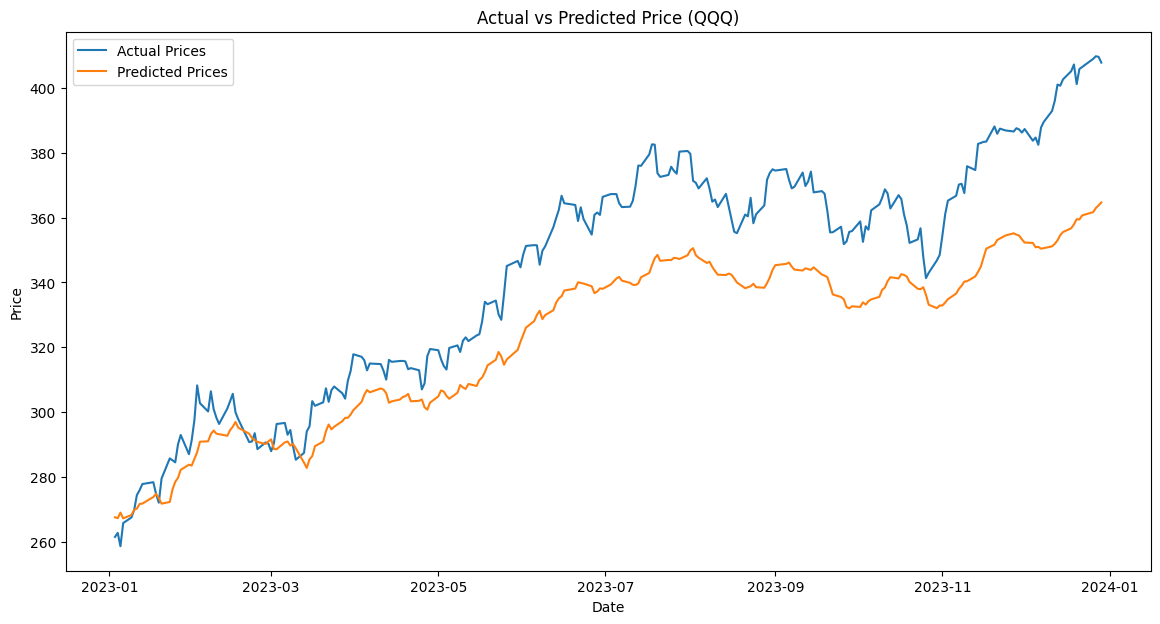

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test, label='Actual Prices')
plt.plot(test_data.index, predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Price (QQQ)')
plt.legend()
plt.show()